In [1]:
import numpy as np
import torch
from torchvision import transforms, models, datasets
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [2]:
device =torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [3]:

# root = "./images/snowmodelimages"
# transformation = transforms.Compose([transforms.Resize((224,224)),
#                                      transforms.ToTensor()
#                                     ])
# data = datasets.ImageFolder(root = root, transform=transformation)

# csvloader = torch.utils.data.DataLoader(data, batch_size = 1, shuffle = True)
# snow, nosnow = [], []
# for img, lbl in csvloader:
#     if(lbl == 1):
#         snow.append(img)
# snow = torch.cat(snow, dim = 0)

# train_snow, test_snow = torch.split(snow, [int(0.8*len(snow)), len(snow) - int(0.8*len(snow))])
# print('data loaded')
# for num,part in enumerate(torch.split(train_snow,10)):
#     torch.save(part, f'train_patches_snow{num}.pt')
# for num,part in enumerate(torch.split(test_snow,10)):
#     torch.save(part, f'test_patches_snow{num}.pt')

# for img, lbl in csvloader:
#     if(lbl == 0):
#         nosnow.append(img)
# nosnow = torch.cat(nosnow, dim = 0)

# train_nosnow, test_nosnow = torch.split(nosnow, [int(0.8*len(nosnow)), len(nosnow) - int(0.8*len(nosnow))])
# print('data loaded')

# for num,part in enumerate(torch.split(train_nosnow,10)):
#     torch.save(part, f'train_patches_nosnow{num}.pt')
# for num,part in enumerate(torch.split(test_nosnow,10)):
#     torch.save(part, f'test_patches_nosnow{num}.pt')




In [4]:
transformation = transforms.Compose([transforms.RandomPerspective(0.6, p=0.5),transforms.GaussianBlur(5)])

class riverdataset(torch.utils.data.Dataset):
    def __init__(self, snow_file, nosnow_file, transform = None):
        """
        Arguments:
            snow_file (string): Path to the .pt file
            nosnow_file (string): Path to the .pt file
            noise (boolean): add guassian noise
        """
        snow = torch.load(snow_file)
        nosnow = torch.load(nosnow_file)
        labels1 = torch.tensor([1 for i in range(len(snow))])
        labels0 = torch.tensor([0 for i in range(len(nosnow))])
        self.data = torch.cat([snow, nosnow], dim= 0)
        self.labels = torch.cat([labels1, labels0], dim = 0)
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = self.data[idx]
        if(self.transform):
            image = self.transform(image)
        return image, self.labels[idx]
    

train_set = riverdataset("train_snow.pt", "train_nosnow.pt", transformation)
test_set = riverdataset('test_snow.pt', "test_nosnow.pt", False)


In [5]:
#Create additional layers for snow classification
model = models.resnet50(weights =models.ResNet50_Weights.IMAGENET1K_V2)
for param in model.parameters():
    param.requires_grad = False   

model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128,2),
    torch.nn.Softmax(dim= 1)
)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
#parameters

lr = 0.0001
batch_size = 256
epochs =20
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr)
train_loader = torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size= 1, shuffle= False)

In [7]:
def calc_test_accuracy(model, dataloader,epoch, save_pic = False, criterion =torch.nn.CrossEntropyLoss()):
      model.eval()
      TP = 0
      FP = 0
      TN = 0
      FN = 0
      val_loss = 0
      with torch.no_grad():
            for num, (i, l) in enumerate(dataloader):
                  if(save_pic):     
                        plt.imsave(f"image{num}.png",i.squeeze(0).permute(1,2,0).numpy() )
                 
                  if(l == torch.tensor([0])):
                        l = torch.tensor([1, 0])
                  else:
                        l = torch.tensor([0, 1])
                  l = l.reshape([1,2])
                  i,l = i.to(device), l.to(device).float()
                  t_out = model(i)
                  
                  
                  val_loss+= criterion(t_out, l).item()
                  predicted = np.argmax(t_out.cpu().numpy(), axis = 1)
                  true_label = np.argmax(l.cpu().numpy(), axis =1)
                 
                  if(predicted == 1 and true_label == 1):
                        TP +=1
                  elif(predicted == 0 and true_label == 0):
                        TN +=1
                  if(predicted == 1 and true_label == 0):
                        FP +=1
                        #plt.imsave(f"imageFP{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
                  elif(predicted == 0 and true_label == 1):
                        FN +=1
                        #plt.imsave(f"imageFN{num}.png",i.cpu().squeeze(0).permute(1,2,0).numpy() )
            try:
                  precision = TP/(TP + FP)
            except:
                  precision = 0
            try:
                  recall = TP/(TP + FN)
            except:
                  recall = 0
            stats = dict(
                  epoch = epoch,
                  accuracy = (TN+TP) /(TP+TN+FP+FN),
                  precision = precision,
                  recall = recall,
                  loss = val_loss/(TP+FP+TN+FN)
            
            )
            # print(f'True positives: {TP}')
            # print(f'True negatives: {TN}')
            # print(f'False positives: {FP}')
            
            # print(f'False negatives: {FN}')
            return stats


In [8]:

#training loop
running_loss = 0 
train_loss, test_loss = [],[]
# model = torch.load("model.pth")
model.train()
verbose = 10
steps = 0

for epoch in range(0, epochs):
    print(epoch)
    for images,labels in train_loader:
        steps +=1
        labels = torch.nn.functional.one_hot(labels)
        images,labels = images.to(device), labels.to(device).float()
        optimizer.zero_grad()
        out = model(images)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        
    val_loss = 0
    num_correct = 0
    model.eval()
    train_loss.append(running_loss/len(train_loader))
    
    with torch.no_grad():
        stats = calc_test_accuracy(model, test_loader, epoch+1)
        
        test_loss.append(stats["loss"])
        stats["training_loss"] = train_loss
        torch.save(stats, f"stats-{epoch+1}.pt")
        print(stats)
    running_loss= 0
    model.train()
    torch.save(model, 'model.pth')
    
  


        
    

0
{'epoch': 1, 'accuracy': 0.5700280112044818, 'precision': 0.5708274894810659, 'recall': 0.9975490196078431, 'loss': 0.6672846922019616, 'training_loss': [0.678159718712171]}
1
{'epoch': 2, 'accuracy': 0.5882352941176471, 'precision': 0.5811965811965812, 'recall': 1.0, 'loss': 0.6351568182977307, 'training_loss': [0.678159718712171, 0.6330458720525106]}
2
{'epoch': 3, 'accuracy': 0.7773109243697479, 'precision': 0.7211367673179396, 'recall': 0.9950980392156863, 'loss': 0.5916067855615242, 'training_loss': [0.678159718712171, 0.6330458720525106, 0.5883975674708685]}
3
{'epoch': 4, 'accuracy': 0.8837535014005602, 'precision': 0.8540305010893247, 'recall': 0.9607843137254902, 'loss': 0.5486518090345612, 'training_loss': [0.678159718712171, 0.6330458720525106, 0.5883975674708685, 0.5479786644379298]}
4
{'epoch': 5, 'accuracy': 0.9173669467787114, 'precision': 0.9330024813895782, 'recall': 0.9215686274509803, 'loss': 0.5117234408187599, 'training_loss': [0.678159718712171, 0.63304587205251

In [9]:
model = torch.load('model.pth')
stats = calc_test_accuracy(model, test_loader, epoch+1)
stats["training_loss"] = train_loss
torch.save(stats, f"stats-{epoch+1}.pt")
print(stats)



{'epoch': 20, 'accuracy': 0.9593837535014006, 'precision': 0.9922077922077922, 'recall': 0.9362745098039216, 'loss': 0.38464040386409654, 'training_loss': [0.678159718712171, 0.6330458720525106, 0.5883975674708685, 0.5479786644379298, 0.5174391642212868, 0.4916996310154597, 0.46971560766299564, 0.45964931199947995, 0.44839222480853397, 0.44022179394960403, 0.4300587475299835, 0.4275010774532954, 0.41697484999895096, 0.4114526684085528, 0.40647590657075244, 0.4008097971479098, 0.40223882098992664, 0.3955116346478462, 0.39626504977544147, 0.39012407263120014]}


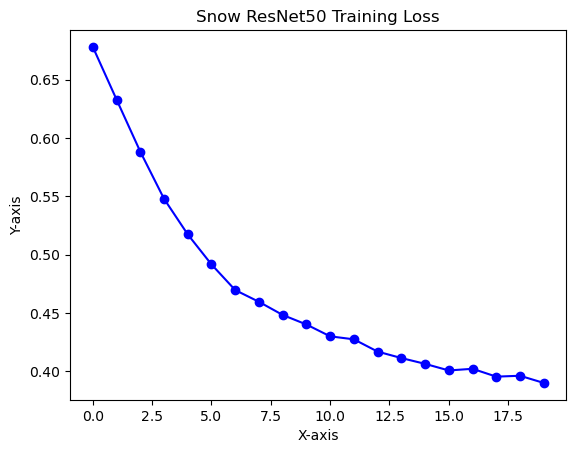

In [10]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(train_loss, marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow ResNet50 Training Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

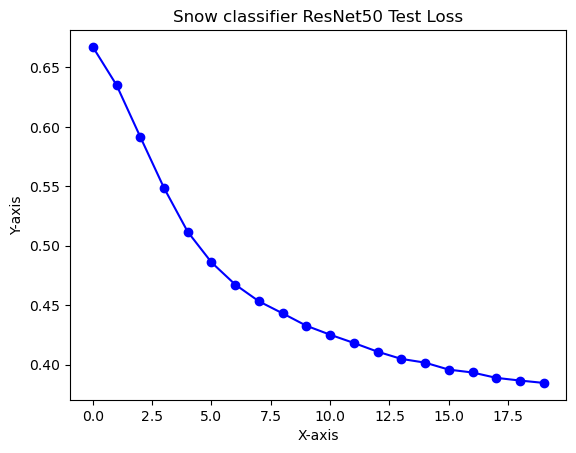

In [11]:
fig, ax = plt.subplots()

# Plot the data
ax.plot(test_loss,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow classifier ResNet50 Test Loss')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

[0.5700280112044818, 0.5882352941176471, 0.7773109243697479, 0.8837535014005602, 0.9173669467787114, 0.9257703081232493, 0.9313725490196079, 0.9299719887955182, 0.9355742296918768, 0.9355742296918768, 0.9425770308123249, 0.9425770308123249, 0.9523809523809523, 0.9537815126050421, 0.9537815126050421, 0.957983193277311, 0.9565826330532213, 0.957983193277311, 0.9649859943977591, 0.9593837535014006]


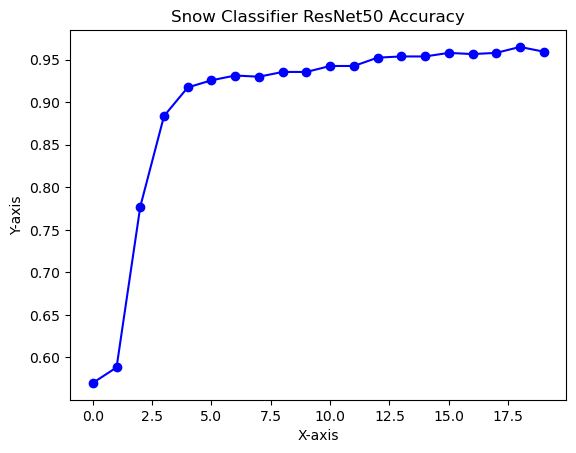

In [12]:
accuracies = []
fig, ax = plt.subplots()
for i in range(1,21):
    accuracies.append(torch.load(f'stats-{i}.pt')['accuracy'])
# Plot the data
print(accuracies)
ax.plot(accuracies,marker='o', linestyle='-', color='b')

# Customize the plot
ax.set_title('Snow Classifier ResNet50 Accuracy')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')

# Display the plot
plt.show()

